# Interpret the results obtained from each of the experiments

The results from the experiments involve interpreting and plotting several quantities
- CPU Utilization of the slaves during the experiments
- IO Wait of the slaves during the experiments
- Accuracy of the final model after 10 epochs
- Response time of the model after 10 epochs

(Possible other result to see)
- Throughput of the model

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from collections import defaultdict
import glob
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols


## Extract from the log files the Accuracy and the Response Time

The files are in the folder from the master server, and we get a final line in the files with
the total wall clock time and the final accuracy

The folder structure taken into consideration is the following, from the root folder for the set
of experiments in question (2k or full) we get 4 folders, 1 for the master and 1 for each slave,
and inside these folders we get 1 folder for each of the replications. Inside we should find the
pickle files and the log files in case of the master


In [2]:
from typing import List, Dict


# Create some class to comfortably save the experiments and their results
class Experiment:
    def __init__(self, name: str):
        """Given the name of the experiment, extract the number of cpu's
        and so on"""
        self._name = name

        # Extract the cpu, batch and njobs by splitting
        parts = name.split('-')
        self.cpu = int(parts[0].replace('cpu', '').strip())
        self.batch = int(parts[1].replace('batch', '').strip())
        self.njobs = int(parts[2].replace('njobs', '').strip())

    # Override the hash function so we can use it as
    # key of the dictionary
    def __hash__(self):
        return self._name

class ExperimentResults:

    def __init__(self, time: float, accuracies: List[float]):
        self.time = time
        self.accuracies = accuracies
        self.final_accuracy = accuracies[-1]


In [3]:

def split_name(exp_name: str) -> (int, int, int):
    """Given the name of the file give back the settings of the experiment"""
    parts = exp_name.split('-')
    cpu = int(parts[0].replace('cpu', '').strip())
    batch = int(parts[1].replace('batch', '').strip())
    njobs = int(parts[2].replace('njobs', '').strip())
    network = str(parts[3])[3:] if len(parts) > 3 else 'lenet'

    return cpu, batch, njobs, network

# Read the folder os the master and search for the accuracy to build the dictionary
# Right now for testing it just has one replication

# This is the path we should change to either analyze the 2k or the full factorial
path_root_master = './experiments/fullfact/master/'

# get the log files
logs = glob.glob(os.path.join(path_root_master, '*.log'))

# Get a dict ready to transform into a dataframe for training of the
# model and representation
results = {
    'exp_name': [],
    'cpu': [],
    'batch': [],
    'njobs': [],
    'network': [],
    'time': [],
    'accuracies':[],
    'final_accuracy': []
}
# Just take the final valuie for the ANOVA test
# res_final = defaultdict(dict)



print(f'Extracting the data from {len(logs)} files')
for log in logs:
    acc = []
    with open(log, 'r') as f:
        for line in f:
            if 'Top1Accuracy is Accuracy' in line:
                try:
                    _accuracy = line.strip().split(']')[-1].split(',')[-1].split(':')[-1].replace(')', '')
                    acc.append(float(_accuracy.strip()))
                except Exception as e:
                    print('Error while reading accuracy',e)
                if len(acc) == 10:
                    # Then save the time here
                    time = float(line.strip().split(']')[-2].split('[')[-1].split(' ')[-1].replace('s', ''))
                    break
    # Add the results to the dictionary
    variables = log.split('-')[1:]
    name = '-'.join(variables).replace('.log', '')
    cpu, batch, njobs , network= split_name(name)
    # set all the columns
    results['cpu'].append(cpu)
    results['batch'].append(batch)
    results['njobs'].append(njobs)
    results['network'].append(network)
    results['accuracies'].append(acc)
    results['time'].append(time)
    results['final_accuracy'].append(acc[-1])
    results['exp_name'].append(name)


results_df = pd.DataFrame(results)
# results_df = results_df.set_index('exp_name')

# We should get the last accuracy to run ANOVA but to plot this is better
results_df


Extracting the data from 96 files
Error while reading accuracy could not convert string to float: 'validate model throughput is 23402.63 records/second'
Error while reading accuracy could not convert string to float: 'Save model to /tmp/simplenet/20201021_135727'


,exp_name,cpu,batch,njobs,network,time,accuracies,final_accuracy
0,cpu1-batch64-njobs1,1,64,1,lenet,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567
1,cpu2-batch64-njobs1,2,64,1,lenet,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580
2,cpu4-batch256-njobs1,4,256,1,lenet,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288
3,cpu8-batch256-njobs1,8,256,1,lenet,153.905961,"[0.6872, 0.7999, 0.8486, 0.8739, 0.8889, 0.9, ...",0.9213
4,cpu1-batch512-njobs1,1,512,1,lenet,179.730715,"[0.5992, 0.7516, 0.7949, 0.8287, 0.8485, 0.864...",0.8957
...,...,...,...,...,...,...,...,...
91,cpu8-batch256-njobs5-netsimplenet,8,256,5,simplenet,254.219420,"[0.8659, 0.8906, 0.9025, 0.9089, 0.9132, 0.917...",0.9269
92,cpu1-batch512-njobs5-netsimplenet,1,512,5,simplenet,254.219420,"[0.8181, 0.8674, 0.8852, 0.8919, 0.8994, 0.903...",0.9108
93,cpu2-batch512-njobs5-netsimplenet,2,512,5,simplenet,96.711085,"[0.8133, 0.8663, 0.8828, 0.8914, 0.9002, 0.903...",0.9143
94,cpu4-batch512-njobs5-netsimplenet,4,512,5,simplenet,111.249790,"[0.822, 0.8697, 0.8845, 0.8936, 0.8984, 0.9037...",0.9147


In [4]:
results_df.groupby('network').mean()

,cpu,batch,njobs,time,final_accuracy
network,,,,,
lenet,3.75,240.0,3.0,315.457036,0.930652
simplenet,3.75,240.0,3.0,281.989544,0.931669


# Extract the CPU and IO wait from the pickle files

In this case we need the slave folders (we will check that the folder contains the word slave to analyze the files)
and we will extract the pickle files from where we will get the CPU load and the IO wait percentage

There is a thing to take in mind. The experiment runs for a default of 5 minutes, so if the experiment lasted
less than 300 seconds, which we can get from the results dictionary from before, we should trim the vectors taking
into account that each measurement is taken every 2 seconds so it just comprises that experiment and doesn't
introduce noise from the next

In [5]:
def coalesce_metrics(loads, threshold = 1):
    """We have three slaves, and sometimes not all of them are working
    if the numnber of cpus and jobs is just one

    In these cases,  discard the lists with an average too close to zero,
    if not, add the slaves together and calculate the mean at each point to
    get the final vector."

    :param: threshold: the threshold of utilization under which we conside
                        that the server was not used in the experiment"""
    # Dict to build the dataframe
    avg_loads = {
        'exp_name' :[],
        'cpu_load': [],
        'iowait': [],
        'cpu_mean': [],
        'iowait_mean':[]
    }

    for exp, slaves in loads.items():
        # print(f'\n{exp}')
        count = 0
        list_length = len(list(slaves['slave1'].values())[0])
        c = np.zeros(list_length)
        io = np.zeros(list_length)
        for slave, metrics in slaves.items():

            # if the mean is too slow discard
            cpu_mean = np.mean(metrics['cpu'])
            if  cpu_mean <threshold:
                # print(f'Discarding {slave} with cpu mean =',cpu_mean)
                pass
            else:
                c += metrics['cpu']
                io += metrics['iowait']
                count += 1
                # print(slave, np.mean(metrics['cpu']), np.mean(metrics['iowait']))
                # print(metrics['cpu'])

        # print('dividing by ',count)
        avg_loads['exp_name'].append(exp)
        avg_loads['cpu_load'].append(c / count)
        avg_loads['iowait'].append(io/count)
        avg_loads['cpu_mean'].append(np.mean(c/count))
        avg_loads['iowait_mean'].append(np.mean(io/count))


        # avg_loads[exp] = {
        #     'cpu': c / count,
        #     'iowait': io/count,
        #     'cpu_mean': np.mean(c/count),
        #     'iowait_mean':np.mean(io/count)
        # }

    return avg_loads

In [6]:
root_folder_slaves = './experiments/fullfact/'

dirs = os.listdir(root_folder_slaves)
slave_dirs = [f for f in dirs if 'slave' in f]


loads = defaultdict(dict)
# The shape of the results is
# name of the file:
#     - slave 1:
#         - cpu: list
#         - iowait: list
#     - slave 2:
#         ...

# Do the same in all the folders
for folder in slave_dirs:
    print('Processing files for the', folder)
    # get just the pickle files
    files = glob.glob(os.path.join(root_folder_slaves, folder, '*.pkl'))

    # Extract the dictionary from each file
    for f in files:

        # Get the name of the experiment to index the other dict
        variables = f.split('-')[1:]
        exp_name = '-'.join(variables).replace('.pkl', '')
        # print(exp_name)

        with open(f, 'rb') as pickle_file:
            metrics = pickle.load(pickle_file)

        # Now we need to check to just get the metrics concerning the experiment
        # And not the following. We leave a margin of 10 seconds or 5 list positions just in case
        # to not cut too tightly
        exp_length = results_df.loc[results_df.exp_name == exp_name, 'time'].array[0]
        if exp_length > 300:
            loads[exp_name][folder] = metrics

        else:
            max_list_length = math.ceil(exp_length/2) + 5
            # print(f'Exp length was {exp_length}, so max list positions are {max_list_length}')
            if max_list_length < len(metrics['cpu']):
                loads[exp_name][folder] = dict()
                loads[exp_name][folder]['cpu'] = metrics['cpu'][:max_list_length]
                loads[exp_name][folder]['iowait'] = metrics['iowait'][:max_list_length]
            else:
                # Add the whole of it
                loads[exp_name][folder] = metrics

# Get the average usage of the experiments
# The resulting dict will just map each
# pf the experiments to its avg cpu load and
# iowait across all slaves

avg_loads = coalesce_metrics(loads)
loads_df = pd.DataFrame(avg_loads)
loads_df

Processing files for the slave1
Processing files for the slave2
Processing files for the slave3


,exp_name,cpu_load,iowait,cpu_mean,iowait_mean
0,cpu1-batch64-njobs1,"[0.0, 0.0, 0.1, 0.0, 0.0, 3.2, 9.9, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.8, 0.0, 0.0, ...",3.802667,0.170000
1,cpu2-batch64-njobs1,"[0.0, 0.0, 0.0, 5.55, 6.05, 0.75, 5.45, 7.6, 7...","[0.0, 0.0, 0.0, 0.15, 0.5, 0.0, 1.55, 3.0, 1.4...",3.190667,0.078333
2,cpu4-batch256-njobs1,"[0.0, 0.0, 1.7999999999999998, 11.266666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.5, 1.76666666...",5.596748,0.126016
3,cpu8-batch256-njobs1,"[0.0, 0.0, 2.1666666666666665, 17.966666666666...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.73...",10.900000,0.397561
4,cpu1-batch512-njobs1,"[0.0, 0.0, 0.0, 9.5, 2.6, 2.7, 8.2, 14.6, 18.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 2.6, 0.0, ...",5.808421,0.053684
...,...,...,...,...,...
91,cpu8-batch256-njobs5-netsimplenet,"[0.0, 0.10000000000000002, 0.06666666666666667...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.0,...",35.709524,5.887970
92,cpu1-batch512-njobs5-netsimplenet,"[19.433333333333334, 2.1333333333333333, 2.133...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.070677,0.285714
93,cpu2-batch512-njobs5-netsimplenet,"[0.0, 0.10000000000000002, 0.6, 2.766666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76666666...",17.262346,0.522840
94,cpu4-batch512-njobs5-netsimplenet,"[0.0, 0.0, 0.03333333333333333, 2.933333333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0666666666666...",25.111475,2.204372


### Merge the dataframes together so we get a common dataframe for all results


In [7]:
# Merge the two dataframes so we get all the data grouped by experiment number
results_df = results_df.merge(loads_df, on='exp_name')

results_df

,exp_name,cpu,batch,njobs,network,time,accuracies,final_accuracy,cpu_load,iowait,cpu_mean,iowait_mean
0,cpu1-batch64-njobs1,1,64,1,lenet,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567,"[0.0, 0.0, 0.1, 0.0, 0.0, 3.2, 9.9, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.8, 0.0, 0.0, ...",3.802667,0.170000
1,cpu2-batch64-njobs1,2,64,1,lenet,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580,"[0.0, 0.0, 0.0, 5.55, 6.05, 0.75, 5.45, 7.6, 7...","[0.0, 0.0, 0.0, 0.15, 0.5, 0.0, 1.55, 3.0, 1.4...",3.190667,0.078333
2,cpu4-batch256-njobs1,4,256,1,lenet,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288,"[0.0, 0.0, 1.7999999999999998, 11.266666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.5, 1.76666666...",5.596748,0.126016
3,cpu8-batch256-njobs1,8,256,1,lenet,153.905961,"[0.6872, 0.7999, 0.8486, 0.8739, 0.8889, 0.9, ...",0.9213,"[0.0, 0.0, 2.1666666666666665, 17.966666666666...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.73...",10.900000,0.397561
4,cpu1-batch512-njobs1,1,512,1,lenet,179.730715,"[0.5992, 0.7516, 0.7949, 0.8287, 0.8485, 0.864...",0.8957,"[0.0, 0.0, 0.0, 9.5, 2.6, 2.7, 8.2, 14.6, 18.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 2.6, 0.0, ...",5.808421,0.053684
...,...,...,...,...,...,...,...,...,...,...,...,...
91,cpu8-batch256-njobs5-netsimplenet,8,256,5,simplenet,254.219420,"[0.8659, 0.8906, 0.9025, 0.9089, 0.9132, 0.917...",0.9269,"[0.0, 0.10000000000000002, 0.06666666666666667...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.0,...",35.709524,5.887970
92,cpu1-batch512-njobs5-netsimplenet,1,512,5,simplenet,254.219420,"[0.8181, 0.8674, 0.8852, 0.8919, 0.8994, 0.903...",0.9108,"[19.433333333333334, 2.1333333333333333, 2.133...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.070677,0.285714
93,cpu2-batch512-njobs5-netsimplenet,2,512,5,simplenet,96.711085,"[0.8133, 0.8663, 0.8828, 0.8914, 0.9002, 0.903...",0.9143,"[0.0, 0.10000000000000002, 0.6, 2.766666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76666666...",17.262346,0.522840
94,cpu4-batch512-njobs5-netsimplenet,4,512,5,simplenet,111.249790,"[0.822, 0.8697, 0.8845, 0.8936, 0.8984, 0.9037...",0.9147,"[0.0, 0.0, 0.03333333333333333, 2.933333333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0666666666666...",25.111475,2.204372


## Plot the loads for each of the slaves for each of the experiments

In some experiments some of the slaves have zero load cause they are not used, in those cases
we should filter out the lists whose average is too close to zero. In other cases, we can just average the
load among all of the slaves.

### See the relationship with time

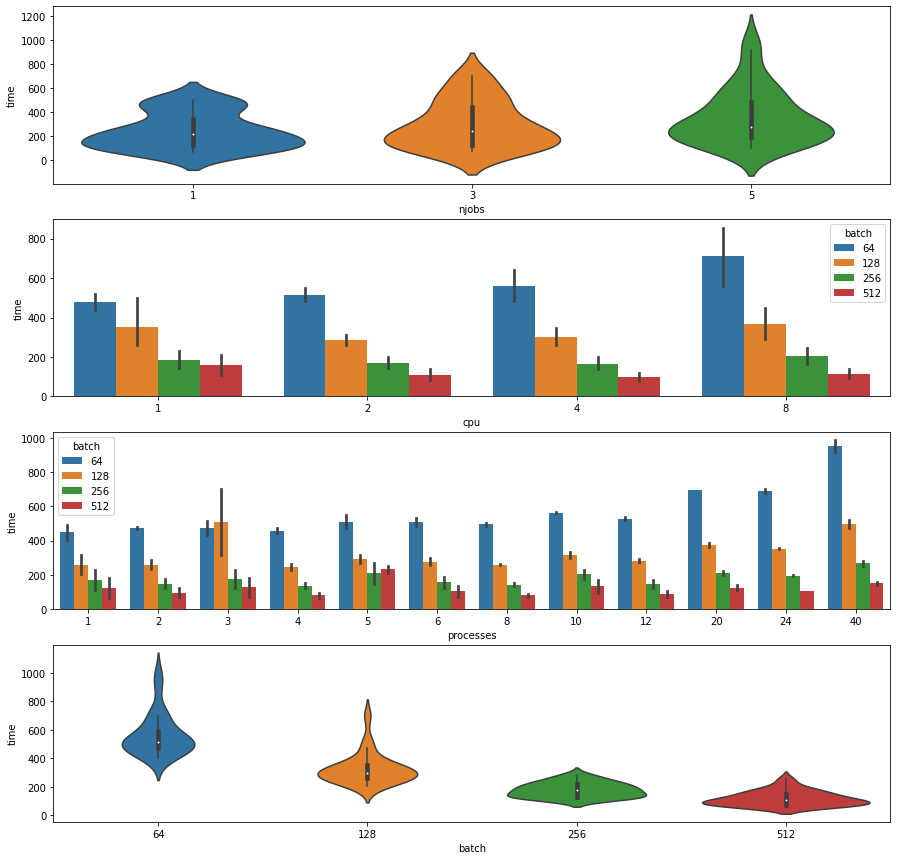

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='time', data=results_df, ax=ax1)
sns.barplot(x='cpu', y='time', hue='batch', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='time', hue='batch',data=results_df, ax=ax3)
sns.violinplot(x='batch', y='time', data=results_df, ax=ax4);


### See the relationships with the accuracy


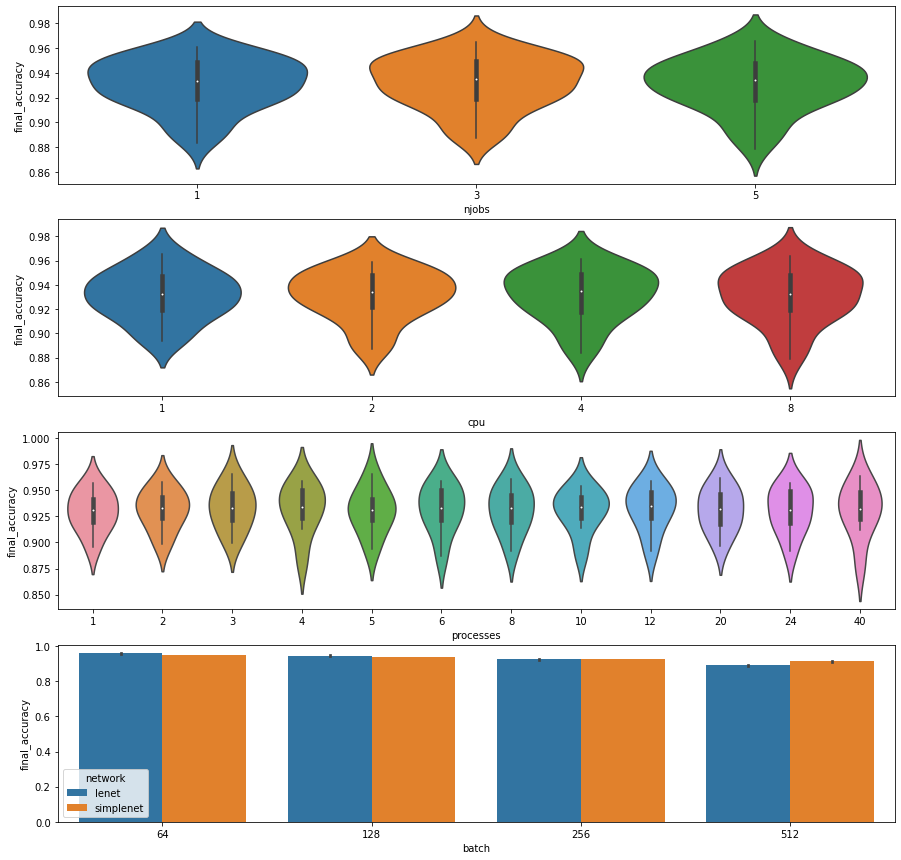

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='final_accuracy', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='final_accuracy', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.violinplot(x='processes', y='final_accuracy', data=results_df, ax=ax3)
sns.barplot(x='batch', y='final_accuracy', hue='network', data=results_df, ax=ax4);


### See the relationship with the cpu load and iowait

,cpu,njobs,time,final_accuracy,cpu_mean,iowait_mean,processes
batch,,,,,,,
64,3.75,3.0,566.366869,0.954517,11.807944,0.802134,11.25
128,3.75,3.0,327.044768,0.942004,12.361999,0.800325,11.25
256,3.75,3.0,180.893276,0.925650,13.624948,1.005777,11.25
512,3.75,3.0,120.588248,0.902471,16.117776,1.702149,11.25


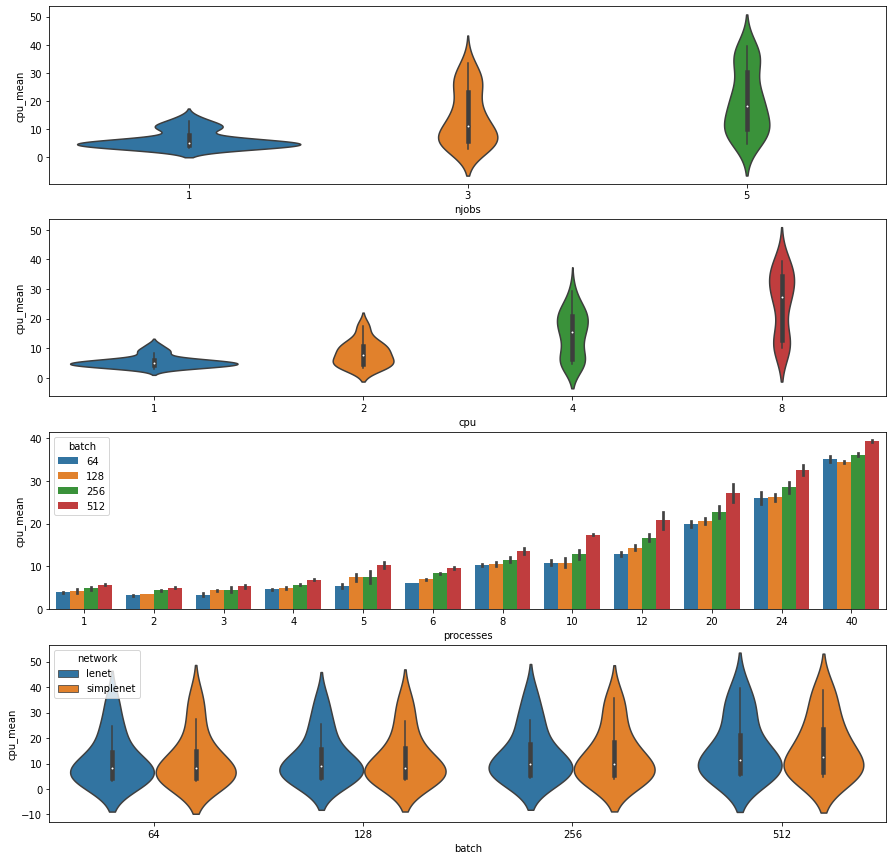

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='cpu_mean', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='cpu_mean', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='cpu_mean', hue='batch', data=results_df, ax=ax3)
sns.violinplot(x='batch', y='cpu_mean', hue = 'network', data=results_df, ax=ax4);


# Surprisingly, the batch size doesn't influence cpu utilization??
results_df.groupby(['batch']).mean()

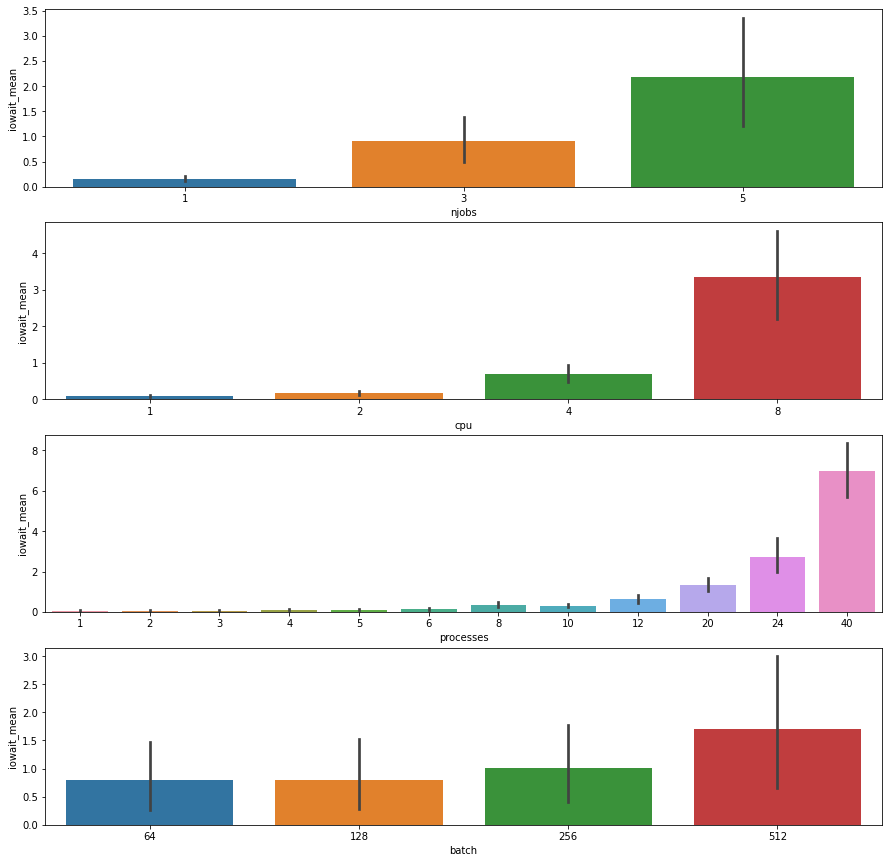

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.barplot(x='njobs', y='iowait_mean', data=results_df, ax=ax1)
sns.barplot(x='cpu', y='iowait_mean', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='iowait_mean', data=results_df, ax=ax3)
sns.barplot(x='batch', y='iowait_mean', data=results_df, ax=ax4);

## Run the ANOVA tests on this data 

We want to see how factors like number of CPUs, Jobs, and Batch influence all the others
- Accuracy
- E(T)
- CPU Usage
- IO Wait

In [16]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the cpu, batch and njobs columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(results_df.groupby(['cpu', 'batch', 'njobs']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs', df).fit()
        
    else:
        if y not in ['final_accuracy', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(results_df.groupby(['cpu', 'batch', 'njobs', 'cpu_mean', 'iowait_mean']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res

In [17]:
# Simply change the output value for the y to the variable that you want to study
# - iowait_mean
# - final_accuracy
# - time
# - cpu_mean
res = ANOVA(results_df, y='time', verbose=True)
res

c:\users\diego\cs\qpe\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\diego\cs\qpe\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


N      Mean        SD        SE  95% Conf.   Interval
cpu batch njobs                                                       
1   64    1      2  448.0996   64.2209   45.4111  -128.9025  1025.1017
          3      2  472.0890   57.0694   40.3542   -40.6593   984.8373
          5      2  509.8118   53.7850   38.0317    26.5728   993.0509
    128   1      2  260.4536   78.9303   55.8122  -448.7070   969.6142
          3      2  508.2235  271.7085  192.1269 -1932.9802  2949.4272
          5      2  291.4653   34.0073   24.0468   -14.0778   597.0083
    256   1      2  172.3205   82.1099   58.0605  -565.4080   910.0490
          3      2  175.9889   71.4537   50.5254  -465.9971   817.9749
          5      2  208.9840   87.5321   61.8945  -577.4607   995.4287
    512   1      2  123.6888   79.2552   56.0419  -588.3913   835.7689
          3      2  126.7857   76.2202   53.8958  -558.0256   811.5971
          5      2  233.2831   29.6085   20.9363   -32.7383   499.3045
2   64    1      2  472.6299    6.7783    4.7930   411.7295   533.5303
          3      2  508.4499   32.8813   23.2506   213.0230   803.8767
          5      2  564.1007    1.0875    0.7690   554.3296   573.8717
    128   1      2  258.7146   36.9291   26.1129   -73.0806   590.5098
          3      2  278.0416   28.5549   20.1914    21.4859   534.5974
          5      2  316.2867   23.3404   16.5041   106.5817   525.9917
    256   1      2  149.2558   34.8390   24.6349  -163.7600   462.2716
          3      2  156.4569   43.8313   30.9934  -237.3518   550.2656
          5      2  202.3351   37.0519   26.1997  -130.5630   535.2333
    512   1      2   94.9283   38.0260   26.8885  -246.7221   436.5788
          3      2  103.1559   42.8026   30.2660  -281.4101   487.7219
          5      2  132.2417   50.2479   35.5307  -319.2180   583.7015
4   64    1      2  458.3359   18.4771   13.0653   292.3259   624.3460
          3      2  528.5074   14.6072   10.3289   397.2668   659.7479
          5      2  697.2447    0.6797    0.4806   691.1376   703.3518
    128   1      2  245.4882   27.0207   19.1066     2.7165   488.2600
          3      2  282.8681   13.4332    9.4987   162.1758   403.5603
          5      2  375.0038   17.3990   12.3030   218.6799   531.3277
    256   1      2  137.5981   22.5159   15.9211   -64.6988   339.8951
          3      2  148.9824   33.2608   23.5189  -149.8540   447.8188
          5      2  211.4399   15.4029   10.8915    73.0507   349.8292
    512   1      2   79.4909   19.6289   13.8798   -96.8682   255.8500
          3      2   89.3520   23.2809   16.4621  -119.8189   298.5229
          5      2  126.2453   21.2068   14.9955   -64.2905   316.7811
8   64    1      2  495.4200   10.6498    7.5306   399.7353   591.1048
          3      2  689.8431   14.8596   10.5074   556.3345   823.3517
          5      2  951.8705   50.1072   35.4311   501.6752  1402.0658
    128   1      2  259.6762    5.2790    3.7329   212.2458   307.1065
          3      2  353.5814    5.5800    3.9457   303.4468   403.7160
          5      2  494.7342   33.1459   23.4377   196.9300   792.5384
    256   1      2  143.1556   15.2033   10.7503     6.5596   279.7516
          3      2  195.8140    7.3186    5.1750   130.0588   261.5691
          5      2  268.3880   20.0374   14.1686    88.3587   448.4173
    512   1      2   80.0221    9.3862    6.6370    -4.3093   164.3535
          3      2  106.5735    1.0739    0.7594    96.9249   116.2220
          5      2  151.2916   10.7748    7.6189    54.4839   248.0992

Overall model F( 7, 88) =  28.659, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     28.66
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           3.53e-20
Time:                        16:38:49   Log-Likelihood:                -586.15
No. Observations:                  96   AIC:                             1188.
Df Residuals:                      88   BIC:                             1209.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         422.9816     71.527      5.914      0.000     280.837     565.126
cpu               -14.2226     15.516     -0.917      0.362     -45.058      16.613
batch              -0.7413      0.242     -3.058      0.003      -1.223      -0.259
cpu:batch           0.0222      0.053      0.423      0.674      -0.082       0.127
njobs              -4.6642     20.941     -0.223      0.824     -46.280      36.952
cpu:njobs          13.1669      4.543      2.898      0.005       4.139      22.195
batch:njobs         0.0444      0.071      0.626      0.533      -0.097       0.185
cpu:batch:njobs    -0.0293      0.015     -1.904      0.060      -0.060       0.001
==============================================================================
Omnibus:                        3.836   Durbin-Watson:                   0.912
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.846
Skew:                           0.469   Prob(JB):                        0.146
Kurtosis:                       2.714   Cond. No.                     3.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,sum_sq,df,F,PR(>F)
cpu,6.234413e+04,1.0,4.854281,3.018944e-02
batch,2.063200e+06,1.0,160.646294,1.487118e-21
cpu:batch,8.773398e+04,1.0,6.831203,1.053576e-02
njobs,2.151680e+05,1.0,16.753558,9.415366e-05
cpu:njobs,6.915558e+04,1.0,5.384639,2.262771e-02
batch:njobs,3.233519e+04,1.0,2.517705,1.161613e-01
cpu:batch:njobs,4.656043e+04,1.0,3.625319,6.017432e-02
Residual,1.130195e+06,88.0,NaN,NaN


## Regress the datapoints we have to get an idea of the performance

In [31]:
# We want to fit the response time based on the number of processes (cpu * jobs) and the batch size

# 1) Transform the dataset
df_regr = results_df[['cpu', 'batch', 'njobs','network', 'time', 'final_accuracy']]
df_regr['processes'] = df_regr['cpu'] * df_regr['njobs']
df_regr = df_regr[['processes', 'batch', 'network', 'time', 'final_accuracy']]

X_init = df_regr[['processes', 'batch', 'network']].reset_index(drop=True)
# Map the network to +-1
X_init['network'] = X_init['network'].apply(lambda net: 1 if net=='lenet' else -1)

# X = df_regr[['cpu','njobs', 'batch']].reset_index(drop=True)
y_time = df_regr['time'].reset_index(drop=True)
y_acc = df_regr['final_accuracy'].reset_index(drop=True)

scaler = StandardScaler()
X = scaler.fit_transform(X_init)
X

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([[-0.93045745, -1.02575529,  1.        ],
       [-0.83968112, -1.02575529,  1.        ],
       [-0.65812844,  0.09325048,  1.        ],
       [-0.2950231 ,  0.09325048,  1.        ],
       [-0.93045745,  1.58525817,  1.        ],
       [-0.83968112,  1.58525817,  1.        ],
       [-0.65812844,  1.58525817,  1.        ],
       [-0.2950231 ,  1.58525817,  1.        ],
       [-0.74890478, -1.02575529,  1.        ],
       [-0.47657577, -1.02575529,  1.        ],
       [ 0.06808225, -1.02575529,  1.        ],
       [ 1.1573983 , -1.02575529,  1.        ],
       [-0.65812844, -1.02575529,  1.        ],
       [-0.74890478, -0.65275337,  1.        ],
       [-0.47657577, -0.65275337,  1.        ],
       [ 0.06808225, -0.65275337,  1.        ],
       [ 1.1573983 , -0.65275337,  1.        ],
       [-0.74890478,  0.09325048,  1.        ],
       [-0.47657577,  0.09325048,  1.        ],
       [ 0.06808225,  0.09325048,  1.        ],
       [ 1.1573983 ,  0.09325048,  1.   

In [ ]:
# Scale the data

%matplotlib inline

scaler = StandardScaler()
xtrain = scaler.fit_transform(X)
# print(xtrain)

# PLot the datapoints
from mpl_toolkits.mplot3d import Axes3D

# plot the train examples
f = plt.figure()
ax = Axes3D(f)
print(xtrain.shape, y.ravel().shape)
ax.scatter(xtrain[:,0], xtrain[:,1], y, c='r')

# Fit a simple linear regression
regressors = [LinearRegression(), Lasso(alpha=1), Ridge(), DecisionTreeRegressor(), RandomForestRegressor()]

# Try with second order stats
x_2 = xtrain**2
xtrain_2 = np.concatenate((xtrain, xtrain**2, xtrain**3), axis =1)
# print(xtrain_2)

for r in regressors:
    loo = LeaveOneOut()

    scores = cross_validate(r, xtrain, y, cv=loo, scoring='neg_mean_squared_error')

    print(r,scores)


x1,x2 = np.meshgrid(np.linspace(-2,2), np.linspace(-2,2))

lr = regressors[0].fit(xtrain, y)
inter = lr.intercept_
coefs = lr.coef_

y_out = coefs[0]*x1+coefs[1]*x2 + inter
print(inter, coefs)
ax.plot_wireframe(x1,x2,y_out);

In [32]:
# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams

from sklearn.model_selection import GridSearchCV, train_test_split

x_train, x_test, y_train_acc, y_test_acc = train_test_split(X, y_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(X, y_time, test_size=0.2, random_state = 42)

reg_acc = RandomForestRegressor(random_state=42)
reg_time = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': [50, 100, 150, 200, 500,1000, 2000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,10),
    'criterion': ['mse', 'mae']
    
}

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

Fitting the time...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:   58.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 1260 out of 1260 | elapsed:  3.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting the accuracy
Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done 296 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 808 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1160 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 1260 out of 1260 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=8,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(4, 10),
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 150, 200, 500, 1000, 2000]},
             verbose=3)

In [33]:
cv_time.best_params_

{'criterion': 'mae',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 50}

In [34]:
cv_acc.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 50}

### Fit the regressors on the accuracy and time

In [36]:
from sklearn.metrics import mean_squared_error

# 1) Fit on the time
r_t = cv_time.best_estimator_.fit(x_train, y_train_time)

# test the performance on the train and the test set
y_pred = r_t.predict(x_test)

err = mean_squared_error(y_pred, y_test_time)

print('Mean Squared Error with the test set is for TIME', err)


# 2) Fit on the acc
r_acc = cv_acc.best_estimator_.fit(x_train, y_train_acc)

# test the performance on the train and the test set
y_pred = r_acc.predict(x_test)
err = mean_squared_error(y_pred, y_test_acc)

print('Mean Squared Error with the test set is for ACCURACY', err)

Mean Squared Error with the test set is for TIME 1597.7368579880053
Mean Squared Error with the test set is for ACCURACY 1.8683460366070817e-05


In [ ]:
# Run some examples with it

## Create the Final Optimizer that will multiplex the regressors seen above

In [42]:
# Import the 3 regressors
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_validate


from typing import Tuple, Optional
# Declare the class for the ML model

from dataclasses import dataclass

@dataclass
class Job:
    cpu:int
    njobs: int
    network: int


class Courier:
    """ Courier has 3 parameters to account for utilization, accuracy and response time,
    based on which, and their weights, it chooses the optimal batch size for the task

    labels are in format dict
    accuracy -> labels
    time -> labels
    utilization -> labels
    """

    def __init__(self, alpha: float, beta: float,
                models: dict, scaler, batches=[64,128,256,512]):


        self.batches = np.array(batches).reshape(len(batches), 1)
        

        if alpha + beta !=1:
            raise ValueError('The hyperparameters need to add up to 1')

        # Configure the hyperparams and the training data
        self.alpha = alpha
        self.beta = beta
        
        
        self.scaler = scaler

        # Compute the predictors
        self.acc_model = models['accuracy']
        self.time_model = models['time']

    def optimize(self, job: Job, latency = None):
        acc, t = self._predict(job)
        
        b = self.batches


        if latency:
            # Just take the options that satisfy the requirements
            fit = t[t<latency]
            if len(fit) == 0:
                print('Not a single value fulfills the '
                      'time requirements, selecting minimum time')
                # Return the minimum time
                min_t_idx = np.where(t == t.min())[0][0]
                return self.batches[min_t_idx], (acc[min_t_idx],
                                                 t[min_t_idx])

            else:
                acc = acc[t<latency]
                b = self.batches[t<latency]
                t = t[t<latency]


        # Return the batch that better fulfills the requirements and
        # also return a tuple with the predictions
        sc_a = acc/np.max(acc)
        sc_t = 1-( t/np.max(t))

        sc = self.alpha * sc_a + self.beta * sc_t

        # Get the index of the max score
        max_sc_idx = np.where(sc == sc.max())[0][0]
        return  b[max_sc_idx], (acc[max_sc_idx],
                                           t[max_sc_idx])



    def _fit_model(self, labels):
        """Fit the model to particular labels"""
        reg = self.model
        reg.fit(self.X, labels)
        return reg


    def _preprocess_data(self, X):
        """Standardizes the data"""
        scaler = StandardScaler()
        return scaler.fit_transform(X)

    def _predict(self, job: Job):
        """Predicts the time, accuracy and util with different batches
        and returns the best one given the optims"""

        acc = []
        t = []
        
        # predict the performance of the job with different batches
        for b in self.batches:
            data_point = self.scaler.transform([[job.cpu * job.njobs, b, job.network]])
            _acc = self.acc_model.predict(data_point)
            _t = self.time_model.predict(data_point)
            print(f'Batch {b}, acc = {_acc} and t = {_t}')

            acc.append(_acc)
            t.append(_t)


        return np.array(acc), np.array(t)




In [46]:
# Create the Courier

c = Courier(alpha = 0.98, beta=0.02, 
            models= {
                'accuracy': r_acc,
                'time': r_t
},
           scaler=scaler)

In [47]:
# Get some predidctions from the Courier

j = Job(cpu = 10, njobs=8, network=-1)
batch, prediction = c.optimize(j, latency=400)

print(f'Recommended batch {batch}, predictions {prediction}')

Batch [64], acc = [0.94840507] and t = [914.11793623]
Batch [128], acc = [0.93838265] and t = [409.66707557]
Batch [256], acc = [0.92522572] and t = [181.82810604]
Batch [512], acc = [0.91284016] and t = [127.20340717]
Recommended batch 256, predictions (0.9252257197159567, 181.82810603513997)


## Run the ANOVA test with all of the results


In [ ]:



# Get the last accuracy instead of the list for the accuracy of each of the experiments

df = pd.DataFrame(res_final)

df